In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import xarray as xa
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pathlib import Path
import pathlib
from tqdm import tqdm
from scipy.ndimage import binary_dilation, generic_filter

import netCDF4
import json

from coralshift.utils import file_ops, directories
from coralshift.dataloading import bathymetry
from coralshift.processing import data

In [ ]:
# import sqlite3
# # import sqlalchemy 
# db_path = "/Volumes/MRes Drive/bleaching/Global_Coral_Bleaching_Database_SQLite_11_24_21.db"
# try:
#     conn = sqlite3.connect(db_path)    
# except Exception as e:
#     print(e)

# #Now in order to read in pandas dataframe we need to know table name
# cursor = conn.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(f"Table Name : {cursor.fetchall()}")

# df = pd.read_sql_query('SELECT * FROM Table_Name', conn)
# conn.close()

In [3]:
# all_climate = file_ops.load_merge_nc_files("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area")
gopr = xa.open_dataset("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area/coral_climate_1_12.nc")

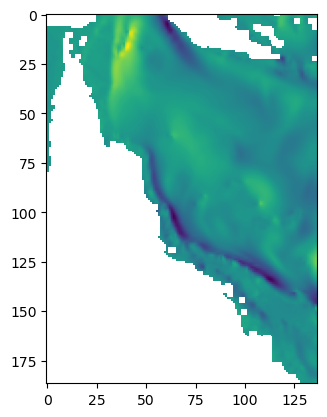

In [4]:
plt.imshow(gopr["vo"].isel(time=-1).values)
data_array = gopr["vo"].values

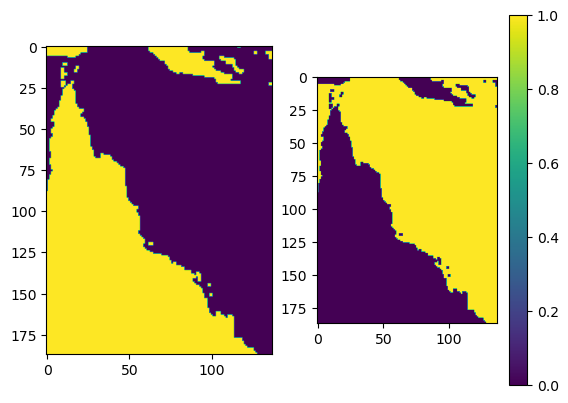

In [5]:
land_mask = (np.all(np.isnan(data_array), axis=2))
sea_mask = ~land_mask
plt.subplot(1, 2, 1)
plt.imshow(land_mask)
plt.subplot(1, 2, 2)
plt.imshow(sea_mask)
plt.colorbar()

test_data shape:  (10, 15)


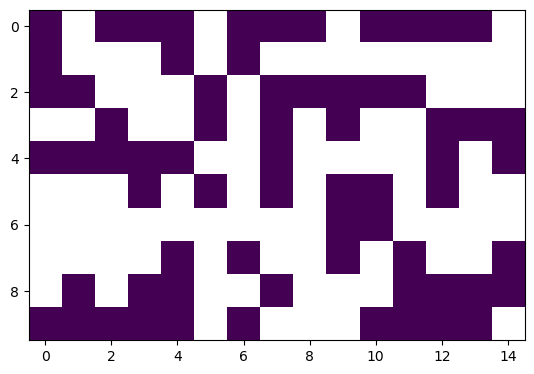

In [6]:
np.random.seed(42)
# test_data = np.repeat(np.random.choice([1,np.nan],size=(10,15))[:,:,np.newaxis], 10, axis=2)
# plt.imshow(test_data[:,:,0])

test_data = np.random.choice([1,np.nan],size=(10,15))
plt.imshow(test_data)
print("test_data shape: ", test_data.shape)

In [7]:
reshaped_array = np.reshape(test_data, (-1, 1))

non_nan_indices = ~np.isnan(reshaped_array)
non_nan_values = reshaped_array[non_nan_indices]

In [8]:
result_array = np.empty_like(reshaped_array)
result_array[non_nan_indices] = non_nan_values
result_array[np.isnan(reshaped_array)] = np.nan

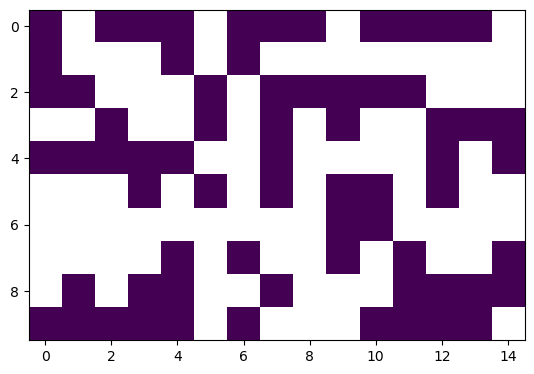

In [9]:
reformed = np.reshape(result_array, (10, 15))
plt.imshow(reformed)

In [10]:
import numpy as np

# Assuming you have a 3D array with shape (axis_1, axis_2, t, p)
array_3d = np.repeat(np.random.choice([1, np.nan], size=(2, 4))[:,:,np.newaxis], 10, axis=2)
array_3d = np.repeat(array_3d[:,:,:,np.newaxis], 3, axis=3)
print("array_3d shape", array_3d.shape)
# Reshape the array to (axis_1 x axis_2, t, p) shape
reshaped_array = array_3d.reshape(-1, array_3d.shape[2], array_3d.shape[3])
print("reshaped_array shape", reshaped_array.shape)


array_3d shape (2, 4, 10, 3)
reshaped_array shape (8, 10, 3)


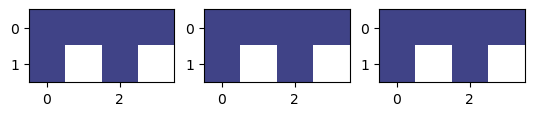

In [11]:
num = 3
f, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(array_3d[:,:,0,i],vmin=0,vmax=5)

In [12]:
variables = data.filter_strings(list(gopr.data_vars), ["spatial_ref", "coral_algae_1-12_degree"])
testing_ds = gopr[variables]
testing_ds

<xarray.Dataset>
Dimensions:    (latitude: 187, longitude: 137, time: 336)
Coordinates:
  * latitude   (latitude) float64 -8.755 -8.838 -8.921 ... -24.09 -24.17 -24.25
  * longitude  (longitude) float64 141.4 141.5 141.6 141.7 ... 152.6 152.7 152.7
    depth      float32 ...
  * time       (time) datetime64[ns] 1993-01-16T12:00:00 ... 2020-12-16T12:00:00
Data variables:
    mlotst     (latitude, longitude, time) float32 ...
    siconc     (latitude, longitude, time) float32 ...
    thetao     (latitude, longitude, time) float32 ...
    usi        (latitude, longitude, time) float32 ...
    sithick    (latitude, longitude, time) float32 ...
    bottomT    (latitude, longitude, time) float32 ...
    vsi        (latitude, longitude, time) float32 ...
    vo         (latitude, longitude, time) float32 nan nan ... -0.03091 0.001534
    uo         (latitude, longitude, time) float32 ...
    so         (latitude, longitude, time) float32 ...
    zos        (latitude, longitude, time) float32 ...

In [13]:
def xa_ds_to_np_array(xa_ds, exclude_vars):
    variables_to_read = data.filter_strings(list(xa_ds.data_vars), exclude_vars)
    excluded_vars = list(set(list(xa_ds.data_vars))-set(variables_to_read))
    array_list = []
    for var in tqdm(variables_to_read, desc="reading variables"):
        vals = xa_ds[var].values
        array_list.append(vals)
    return np.stack(array_list, axis=2), excluded_vars

out, excl = xa_ds_to_np_array(testing_ds, ["depth", "latitude", "longitude", "time", "spatial_ref", "coral_algae_1-12_degree"])

reading variables: 100%|██████████| 11/11 [00:12<00:00,  1.14s/it]


In [14]:
def combine_dims(a, start=0, count=2):
    """ Reshapes numpy array a by combining count dimensions, 
        starting at dimension index start """
    s = a.shape
    return np.reshape(a, s[:start] + (-1,) + s[start+count:])

In [15]:
def remove_nans_4d_array(array, xa_ds: xa.Dataset = None) -> np.ndarray:
    # remove all columns (vars) containing NaN
    var_mask_indices = ~np.all(np.isnan(array), axis=(0,1,3)) # boolean mask indicating which columns to keep
    vars_masked = array[:, :, var_mask_indices, :] # keep only the columns that don't contain entirely NaN values
    
    # remove all depths (times) containing NaN
    time_mask_indices = ~np.all(np.isnan(vars_masked), axis=(0,1,2))
    masked = vars_masked[:,:,:,time_mask_indices]

    if xa_ds:
        data_var_names = list(xa_ds.data_vars)
        print("Excluded variables (contained nan values only). (index, name):")
        print([(i, name) for i, name in enumerate(data_var_names) if not var_mask_indices[i]])
        
        time_values = list(xa_ds.time.values)
        print("Excluded time steps (contained nan values only). (index, time):")
        print([(i, name) for i, name in enumerate(time_values) if not time_mask_indices[i]])

    return masked
    # remove all timesteps for which 

no_major_nans = remove_nans_4d_array(out, testing_ds)

Excluded variables (contained nan values only). (index, name):
[(1, 'siconc'), (4, 'sithick')]
Excluded time steps (contained nan values only). (index, time):
[]


In [16]:
combined = combine_dims(no_major_nans, start=0, count=2)

In [17]:
non_nan_mask = ~np.all(np.isnan(combined), axis=(1,2))

In [18]:
non_nan_mask.shape

(25619,)

In [21]:
reshaped_array.shape

(8, 10, 3)

In [19]:
masked_array = reshaped_array[non_nan_mask,:,:].shape


IndexError: boolean index did not match indexed array along dimension 0; dimension is 8 but corresponding boolean dimension is 25619

In [ ]:
reshaped_array_filled = np.full_like(reshaped_array, np.nan)
reshaped_array_filled[non_nan_mask] = masked_array
reshaped_array_filled = reshaped_array_filled * 5 
reshaped_array_filled.shape

In [ ]:
array_3d_filled = reshaped_array_filled.reshape(array_3d.shape)

In [ ]:
num = 3
f, ax = plt.subplots(1,num)
for i in range(num):
    ax[i].imshow(array_3d_filled[:,:,0,i],vmin=0,vmax=5)

In [ ]:

# Remove NaN values along the first dimension
non_nan_mask = ~np.any(np.isnan(reshaped_array), axis=1)
masked_array = reshaped_array[non_nan_mask]

# Multiply the remaining array by 2
masked_array *= 2

# Reshape the array back to the original shape (axis_1 x axis_2, t, p), with NaN values in the same positions
reshaped_array_filled = np.full_like(reshaped_array, np.nan)
reshaped_array_filled[non_nan_mask] = masked_array

# Reshape back to the original 3D shape
array_3d_filled = reshaped_array_filled.reshape(array_3d.shape)

# Verify the results
print(array_3d)
print(array_3d_filled)

In [ ]:
nans_mask = (np.all(np.isnan(data_array), axis=2))
nans_mask.shape

In [ ]:
lat_shape, lon_shape, time_shape = data_array.shape
# extended_mask = np.repeat(sea_mask[:, :, np.newaxis], time_shape, axis=2)
# extended_mask.shape

In [ ]:
masked = data_array[extended_mask]

In [ ]:
masked.shape


In [ ]:
plt.imshow(data_array[sea_mask,:][0])

In [ ]:
# Assuming your array is named "data_array"
# Find the indices of non-NaN values along the lat and lon axes
nonan_indices = np.where(~np.isnan(data_array[..., 0, 0]))

# Check if any non-NaN values are found
if len(nonan_indices[0]) > 0:
    lat_nonan_indices, lon_nonan_indices = nonan_indices
    # Select the non-NaN values from the array and reshape
    reshaped_array = data_array[lat_nonan_indices, lon_nonan_indices].reshape((-1, data_array.shape[2], data_array.shape[3]))

    # To reshape it back to the original shape with NaN values filled with -1
    original_shape = data_array.shape
    filled_array = np.full(original_shape, -1)
    filled_array[lat_nonan_indices, lon_nonan_indices] = reshaped_array
else:
    # Handle the case where no non-NaN values are found
    filled_array = np.full(data_array.shape, -1)

In [ ]:
plt.imshow(filled_array)

In [ ]:
gopr["vo"].isel(time=-1).plot()

In [ ]:
all_climate.to_netcdf("/Volumes/MRes Drive/global_ocean_reanalysis/monthly_means/baseline_area/gopr_monthly_means_total_area.nc")

In [ ]:
time = xa.cftime_range(start='2022-01-01', end='2022-01-05', freq='D')

# create lat and lon coordinates
lat = np.linspace(-90, 90, 5)
lon = np.linspace(-180, 180, 5)

# create random data for each coordinate
# create random data for each variable and coordinate
data1 = np.random.rand(len(time), len(lat), len(lon))
data2 = np.random.rand(len(time), len(lat), len(lon))
data3 = np.random.rand(len(time), len(lat), len(lon))

# create xarray dataset with time, lat, and lon as coordinates
ds = xa.Dataset({'data1': (['time', 'lat', 'lon'], data1),
                 'data2': (['time', 'lat', 'lon'], data2),
                 'data3': (['time', 'lat', 'lon'], data3)},
                coords={'time': time,
                        'lat': lat,
                        'lon': lon})


# stacked.transpose('time','points').as_numpy()

# np.shape(stacked['data1'].transpose('time','points').to_numpy())

def stacking(ds):
    stacked = ds.stack(points=('lat', 'lon'))
    
    vars_list = list(ds.variables)
    # stack= stacked[vars_list[0]].to_numpy()
    vals = []
    for d in vars_list[:3]:
        vals.append(stacked[d].to_numpy())
        # vals = stacked[d].transpose('time','points').to_numpy()
        # stack = np.stack([stack, vals], axis=1)

    return vals

out = stacking(ds)

In [ ]:
ds

In [ ]:
ds_stacked = ds.stack(location=('lat', 'lon'))
ds_stacked


In [ ]:
list(ds.variables)

In [ ]:



temp = []
for dim in list(ds.variables)[:3]:
    vals = ds_stacked[dim].values
    temp.append(vals)

# move location to first column
swapped=np.moveaxis(temp,2,0)


In [ ]:
np.shape(temp)

In [ ]:
np.shape(swapped[:,:,4])

In [ ]:
data1_array = ds_stacked['data1'].values
np.shape(data1_array)

In [ ]:
concatenated = np.concatenate(temp, axis=1)

In [ ]:
np.shape(concatenated)

In [ ]:
transposed = np.transpose(out, (2, 1, 0))
reshaped = np.reshape(transposed, (25, 5, 3))


In [ ]:
np.shape(reshaped[2])

In [ ]:
out[0]

# Climate data imports

### Climatology Monthly Means
[Source](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/services): ```cmems_mod_glo_phy_my_0.083-climatology_P1M-m```

Contains the average variable values in each month of the year between 1993 and 2020.

In [ ]:
data_dict = file_ops.dict_of_ncs_from_dir("/Volumes/MRes Drive/global_ocean_reanalysis/climatology_monthly_means", engine="h5netcdf")
data_dict["mercatorglorys12v1_gl12_mean_1993_2016_05"]

In [ ]:
(data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"]).dims

In [ ]:
# flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

# one = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"][flat_vars]
# two = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_03"][flat_vars]
# out = xa.concat([one,two], dim="time")
# out

In [ ]:
f,ax1=plt.subplots()
out['zos'][0].plot(ax=ax1)
ax1.axis('equal');

In [ ]:
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]

In [ ]:
for ds in month_datasets:
    print(ds.dims)

In [ ]:
month_datasets[:1][0]

In [ ]:
one = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_02"][flat_vars]
two = data_dict["mercatorglorys12v1_gl12_mean_1993_2016_01"][flat_vars]
xa.concat([one,two], dim="time")

In [ ]:
# 1D variables
flat_vars = ["zos","mlotst","bottomT","sithick","siconc","usi","vsi"]

month_datasets = [data_dict[month][flat_vars] for month in sorted(data_dict.keys())]
# month_datasets[2]
flat_vars_ds = xa.concat(month_datasets, dim='time')

In [ ]:
flat_vars_ds

In [ ]:
# f,ax1=plt.subplots()
# surface_monthly_means['zos'][0].plot(ax=ax1)
# ax1.axis('equal');


In [ ]:
import numpy as np
import xarray as xr

# create x and y coordinates
x = np.arange(0, 4320, 1)
y = np.arange(0, 20410, 1)

# create time coordinate
da1_time = np.arange('2022-01', '2022-03', dtype='datetime64[M]')
da1_time = np.arange('2022-03', '2022-04', dtype='datetime64[M]')


# create data for the first DataArray
data1 = np.random.rand(len(time), len(y), len(x))

# create the first DataArray
da1 = xr.DataArray(data1, coords=[time, y, x], dims=['time', 'y', 'x'])

# create data for the second DataArray
data2 = np.random.rand(len(time), len(y), len(x))

# create the second DataArray
da2 = xr.DataArray(data2, coords=[time, y, x], dims=['time', 'y', 'x'])


In [ ]:
xa.concat([da1, da2], dim="time")

In [ ]:
month_datasets = [data_dict[month] for month in sorted(data_dict.keys())]
# month_datasets[2]
concat_data = xa.concat(month_datasets[2:3], dim='time')
# sorted_data = concat_data.sortby('time')


In [ ]:
fig, ax = plt.subplots(12, 1)

for i, array in tqdm(enumerate(out.values())):
    # upsampled_array = upsample_xa_array(array, resolution=1)
    array["bottomT"].plot(ax=ax[i])

# upsampled_array["bottomT"].plot(ax=ax[i])

In [ ]:
fig, ax = plt.subplots(len(out), 1)

for i, array in tqdm(enumerate(out.values())):
    array["mlotst"].plot(ax=ax[i])

In [ ]:
upsample_xa_array(out["mercatorglorys12v1_gl12_mean_1993_2016_05"]['mlotst'])

In [ ]:
(upsample_xa_array(out["mercatorglorys12v1_gl12_mean_1993_2016_05"]['mlotst'])).plot()

In [ ]:
out["mercatorglorys12v1_gl12_mean_1993_2016_08"].variables.keys()

In [ ]:
out["mercatorglorys12v1_gl12_mean_1993_2016_07"].variables["usi"][:][0]

## Ocean Acidification

In [ ]:
acids = read_ncs_from_dir("/Volumes/MRes Drive/ocean_acidification")

In [ ]:
acids["Aragonite_std_historical"]

# MOTU API Call

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

In [ ]:
import numpy as np
from coralshift.dataloading import climate_data
from coralshift.utils import utils

In [ ]:
info_dict = climate_data.generate_name_dict(variables=["bottomT", 
    "mlotst", "so", "thetao", "uo", "vo", "zos"
    ],
    date_lims=(np.datetime64('1993-01-10'), np.datetime64('2023-01-16')), 
    lon_lims=(142, 147),
    lat_lims=(-17, -10), 
    depth_lims=(0,1))

climate_data.generate_spatiotemporal_var_filename_from_dict(info_dict)

In [ ]:
climate_data.download_reanalysis(
    download_dir="/Volumes/MRes Drive/global_ocean_reanalysis/daily", 
    variables=["bottomT", 
    "mlotst", "so", "thetao", "uo", "vo", "zos"
    ],
    date_lims=(np.datetime64('1993-01-10'), np.datetime64('2024-01-16')), 
    lon_lims=(142, 147),
    lat_lims=(-17, -10), 
    depth_lims=(0,41)
)

In [ ]:
parent_dir = "/Volumes/MRes Drive/global_ocean_reanalysis/daily/"
concat_files_common = "merged.nc"
# file_ops.load_merge_nc_files("/Volumes/MRes Drive/global_ocean_reanalysis/daily/bottomT", incl_subdirs=True)

In [ ]:
file_ops.merge_from_dirs(parent_dir, "merged.nc")
# list(Path(parent_dir).glob("**/*" + concat_files_common))

In [ ]:
[x for x in Path(parent_dir).iterdir() if x.is_dir()]

In [ ]:
file_ops.merge_nc_files_in_dirs(parent_dir)

In [ ]:
xa.open_dataarray("/Volumes/MRes Drive/global_ocean_reanalysis/daily/vo/vo_time_merged.nc")

In [ ]:
### ALIGN NC FILES AND WRITE TO NEW
import xarray as xa
import matplotlib.pyplot as plt
from coralshift.utils import file_ops
download_dir = "/Volumes/MRes Drive/global_ocean_reanalysis/daily/New Folder With Items"
nc_files = file_ops.return_list_filepaths(download_dir, ".nc")

In [ ]:
file_ops.load_merge_nc_files(download_dir).coords

In [ ]:
t1 = xa.open_dataarray("/Volumes/MRes Drive/global_ocean_reanalysis/daily/bottomT_dts_2020-01-10_2020-01-12_lon_142-00_143-00_lat_-10-00_-11-00_dep_0-00_1-00.nc")
t2 = xa.open_dataarray("/Volumes/MRes Drive/global_ocean_reanalysis/daily/bottomT_dts_2020-01-12_2020-01-14_lon_142-00_143-00_lat_-10-00_-11-00_dep_0-00_1-00.nc")

In [ ]:
nc_files

In [ ]:
t1.coords

In [ ]:
xa.open_mfdataset(nc_files, combine="nested", concat_dim="time")

In [ ]:
t1

In [ ]:
xa.merge([t1,t2])

In [ ]:
xa.open_mfdataset(file_ops.return_list_filepaths(download_dir, ".nc"), combine="by_coords", combine_attrs="drop")
# plt.plot(file_ops.load_merge_nc_files(download_dir).time.values)